penalty: l1 C: 0.0001
min_df = 2 dimension reduction method: LSI
The accuracy is:
0.5047619047619047
The precision is:
0.0
The recall is:
0.0
The confusion matrix is:
[[1590    0]
 [1560    0]]
penalty: l1 C: 0.0001
min_df = 5 dimension reduction method: LSI
The accuracy is:
0.5047619047619047
The precision is:
0.0
The recall is:
0.0
The confusion matrix is:
[[1590    0]
 [1560    0]]
penalty: l1 C: 0.0001
min_df = 2 dimension reduction method: NMF
The accuracy is:
0.5047619047619047
The precision is:
0.0
The recall is:
0.0
The confusion matrix is:
[[1590    0]
 [1560    0]]
penalty: l1 C: 0.001
min_df = 2 dimension reduction method: LSI
The accuracy is:
0.5047619047619047
The precision is:
0.0
The recall is:
0.0
The confusion matrix is:
[[1590    0]
 [1560    0]]
penalty: l1 C: 0.001
min_df = 5 dimension reduction method: LSI
The accuracy is:
0.5047619047619047
The precision is:
0.0
The recall is:
0.0
The confusion matrix is:
[[1590    0]
 [1560    0]]
penalty: l1 C: 0.001
min_df = 2 

[[1587    3]
 [1183  377]]
penalty: l2 C: 0.1
min_df = 2 dimension reduction method: LSI
The accuracy is:
0.9158730158730158
The precision is:
0.9695431472081218
The recall is:
0.857051282051282
The confusion matrix is:
[[1548   42]
 [ 223 1337]]
penalty: l2 C: 0.1
min_df = 5 dimension reduction method: LSI
The accuracy is:
0.9171428571428571
The precision is:
0.9689530685920578
The recall is:
0.8602564102564103
The confusion matrix is:
[[1547   43]
 [ 218 1342]]
penalty: l2 C: 0.1
min_df = 2 dimension reduction method: NMF
The accuracy is:
0.834920634920635
The precision is:
0.9735883424408015
The recall is:
0.6852564102564103
The confusion matrix is:
[[1561   29]
 [ 491 1069]]
penalty: l2 C: 1
min_df = 2 dimension reduction method: LSI
The accuracy is:
0.9333333333333333
The precision is:
0.9700557103064067
The recall is:
0.892948717948718
The confusion matrix is:
[[1547   43]
 [ 167 1393]]
penalty: l2 C: 1
min_df = 5 dimension reduction method: LSI
The accuracy is:
0.933015873015873

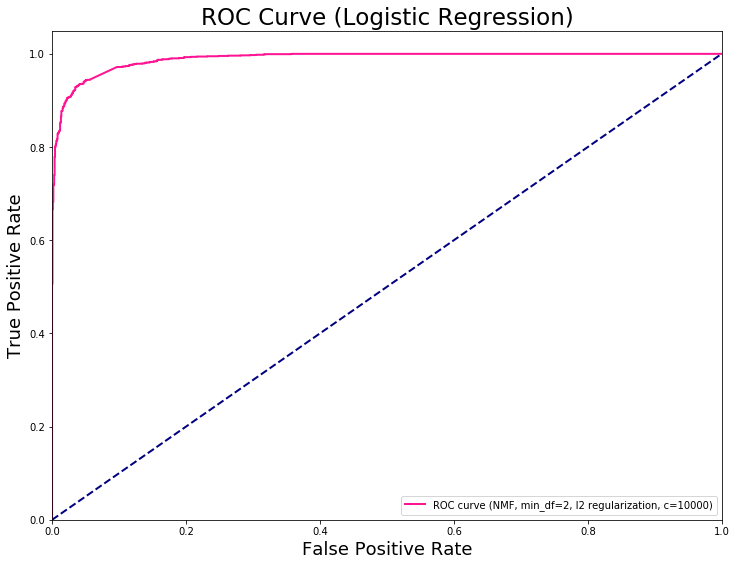

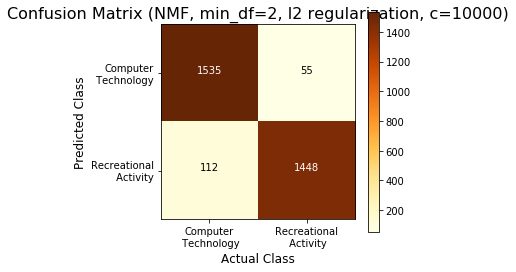

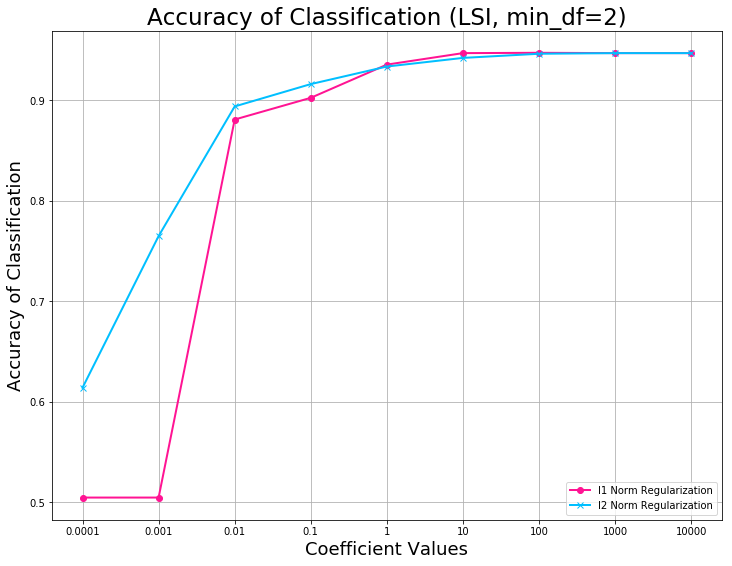

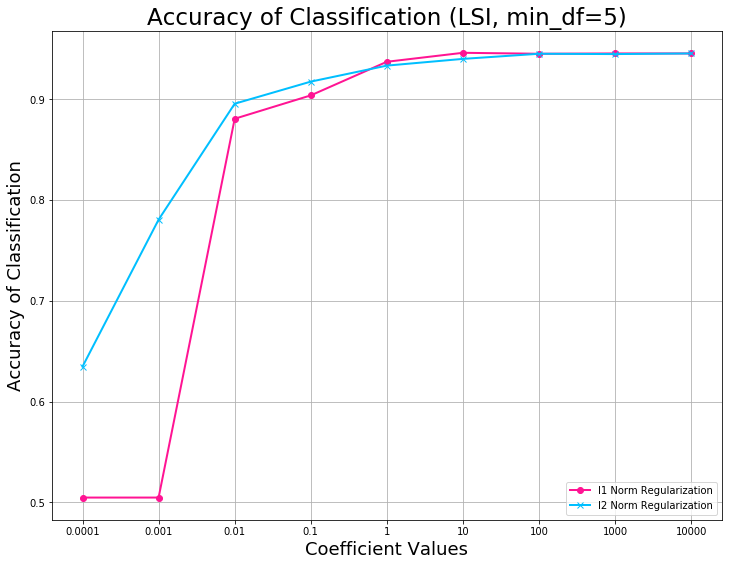

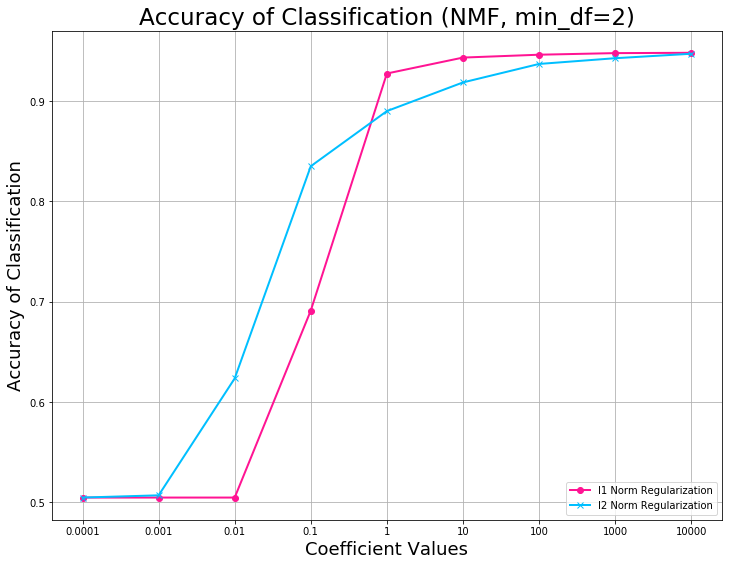

In [13]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools


# fetch original data
computer_technology_subclasses = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
recreational_activity_subclasses = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
comp_tech_train = fetch_20newsgroups(subset='train', categories=computer_technology_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
rec_act_train = fetch_20newsgroups(subset='train', categories=recreational_activity_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
comp_tech_test = fetch_20newsgroups(subset='test', categories=computer_technology_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
rec_act_test = fetch_20newsgroups(subset='test', categories=recreational_activity_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
all_data = comp_tech_train.data+comp_tech_test.data+rec_act_train.data+rec_act_test.data


# map comp_tech class to True and rec_act class to False
classification_train = [True] * len(comp_tech_train.data) + [False] * len(rec_act_train.data)
classification_test = [True] * len(comp_tech_test.data) + [False] * len(rec_act_test.data)


# trim data
stemmer = SnowballStemmer("english")
def trim_and_stem(data_list):
    for i in range(len(data_list)):
        temp = re.findall('[a-zA-Z]+', data_list[i])
        ans = []
        for j in range(len(temp)):
            if not temp[j].isdigit():
                ans.append(stemmer.stem(temp[j])) # stem() turned words into lowercase            
        data_list[i] = " ".join(ans)
trim_and_stem(all_data)


# generate count matrices with min_df = 2 & 5
X_counts = []
for i in [2, 5]:
    count_vect = CountVectorizer(min_df=i, stop_words ='english')
    X_counts.append(count_vect.fit_transform(all_data))


# generate tfidf matrices 
tfidf_transformer = TfidfTransformer()
X_tfidf = []
for i in [0, 1]:
    X_tfidf.append(tfidf_transformer.fit_transform(X_counts[i]))


# extract feature using LSI & NMF
lsi_res = []
svd = TruncatedSVD(n_components = 50, n_iter = 10,random_state = 42)
for i in [0, 1]:
    lsi_res.append(svd.fit_transform(X_tfidf[i]))
nmf = NMF(n_components=50, init='random', random_state=0)
nmf_res = nmf.fit_transform(X_tfidf[0])


# split train and test dataset
split_point_1 = len(comp_tech_train.data)
split_point_2 = split_point_1 + len(comp_tech_test.data)
split_point_3 = split_point_2 + len(rec_act_train.data)
lsi_test = []
lsi_train = []
for i in [0, 1]:
    lsi_test.append(np.concatenate((lsi_res[i][split_point_1 : split_point_2], lsi_res[i][split_point_3:])))
    lsi_train.append(np.concatenate((lsi_res[i][0:split_point_1], lsi_res[i][split_point_2:split_point_3])))
nmf_test = np.concatenate((nmf_res[split_point_1 : split_point_2], nmf_res[split_point_3:]))
nmf_train = np.concatenate((nmf_res[0:split_point_1], nmf_res[split_point_2:split_point_3]))
lsi_test += [nmf_test]
lsi_train += [nmf_train]
test = lsi_test
train = lsi_train

method = ['LSI', 'LSI', 'NMF']
min_df = [2, 5, 2]

dict_acc = {0 : {'l1' : [], 'l2' : []}, 1 : {'l1' : [], 'l2' : []}, 2 : {'l1' : [], 'l2' : []}}
fpr_last = []
tpr_last = []
conf_mat_last = []

# plot confusion matrix
class_names = ['Computer\n Technology', 'Recreational\n Activity']
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.YlOrBr):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)
    

# predict data
def predict(i, l, c):
    classifier = linear_model.LogisticRegression(penalty = l, C=c)
    classifier.fit(train[i], classification_train)

    news_true=classification_test;
    news_predict = classifier.predict(test[i])
    fpr, tpr, thresholds = metrics.roc_curve(classification_test, classifier.predict_proba(test[i])[:, 1])
    if i==2 and l=='l2' and c==10000:
        fpr_last.append(fpr)
        tpr_last.append(tpr)
    
    print 'penalty: ' + l + ' C: ' + str(c)
    print 'min_df = ' + str(min_df[i]) + ' dimension reduction method: ' + str(method[i])
    print 'The accuracy is:'
    acc = metrics.accuracy_score(news_true, news_predict)
    print acc
    print 'The precision is:'
    print metrics.precision_score(news_true, news_predict)
    print 'The recall is:'
    print metrics.recall_score(news_true, news_predict)
    print 'The confusion matrix is:'
    conf_mat = metrics.confusion_matrix(news_true, news_predict)
    if i==2 and l=='l2' and c==10000:
        conf_mat_last.append(conf_mat)
    print conf_mat
    print '======================'
    dict_acc[i][l].append(acc)

cvalues = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for l in ['l1', 'l2']:
    for c in cvalues:
        for i in range(3):
            predict(i, l, c)


# plot ROC curve
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve (Logistic Regression)', fontsize=23)
plt.plot(fpr_last[0], tpr_last[0], color='deeppink', lw=2, label='ROC curve (NMF, min_df=2, l2 regularization, c=10000)')
plt.legend(loc="lower right")
plt.show()

# plot non-normalized confusion matrix
plt.figure()
title = 'Confusion Matrix (NMF, min_df=2, l2 regularization, c=10000)'
plot_confusion_matrix(conf_mat_last[0], classes=class_names, title=title)
plt.show()


# plot accuracy curve
for i in range(3):
    plt.figure(figsize=(12,9))
    x_labels = ['0.0001', '0.001', '0.01', '0.1', '1', '10', '100', '1000', '10000']
    plt.xlabel('Coefficient Values', fontsize = 18)
    plt.ylabel('Accuracy of Classification', fontsize = 18)
    plt.title('Accuracy of Classification ('+method[i]+', min_df='+str(min_df[i])+')', fontsize = 23)
    plt.plot(x_labels, dict_acc[i]['l1'], 'o-', color='deeppink', lw=2, label='l1 Norm Regularization')
    plt.plot(x_labels, dict_acc[i]['l2'], 'x-', color='deepskyblue', lw=2, label='l2 Norm Regularization')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    